In [49]:
import geopandas as gpd
import numpy as np
import pprint
import json
import matplotlib.pyplot as plt

from GDRT.harmonizing import compute_global_shifts_from_pairwise

In [50]:
SHIFTS_PATH = "/ofo-share/scratch-david/georeferencing-experiments/registration_all_pairs.geojson"
OUTPUT_FILE = "/ofo-share/repos-david/UCNRS-experiments/data/shift_per_dataset.json"

# Any pairwise shift greater than this value will be considered an outlier and removed
MAX_PAIRWISE_SHIFT = 10
# The weighting for each dataset to stay in the current location
CURRENT_LOCATION_WEIGHT = 0.01

In [51]:
# Read the pairwise shifts
gdf = gpd.read_file(SHIFTS_PATH)
# Convert into a dictionary mapping from the pair of dataset IDs and the shift between them
shifts = {
    k: v
    for k, v in zip(
        list(zip(gdf["mission_id_1"].to_list(), gdf["mission_id_2"].to_list())),
        list(zip(gdf["xshift"].to_list(), gdf["yshift"].to_list())),
    )
}

# Remove any shifts that are nan, corresponding to failed registration
shifts = {k: v for k, v in list(shifts.items()) if np.all(np.isfinite(v))}
# Remove any shifts that have a very large value, suggesting erronous registration
shifts = {k: v for k, v in list(shifts.items()) if np.all(np.linalg.norm(v) < MAX_PAIRWISE_SHIFT)}

# Get the list of all dataset IDs
all_dataset_ids = gdf["mission_id_1"].to_list() + gdf["mission_id_2"].to_list()
# Give each dataset the same weighting for staying in the original location
dataset_weights = {
    dataset_id: CURRENT_LOCATION_WEIGHT for dataset_id in all_dataset_ids
}

# Weight each shift identically. In the future this could be updated to include some metric of
# confidence in the shift
shift_weights = np.ones(len(shifts))

In [52]:

# Compute the global shift that minimizes all the error terms using least squares.
global_shifts = compute_global_shifts_from_pairwise(
    shifts,
    shift_weights=shift_weights,
    dataset_weights=dataset_weights,
)
# Print the results
pprint.pprint(global_shifts)

# Save them to a jons file
with open(OUTPUT_FILE, "w") as output_h:
    json.dump(global_shifts, output_h, ensure_ascii=True, indent=4, sort_keys=True)

Abotu to run lstqr
{'000479': (1.2597856016331055, 0.8801634159132814),
 '000544': (0.3582739354031727, 0.10503085294322118),
 '000545': (0.6352323176004333, 0.3233759892932425),
 '000546': (0.8271189040534634, 2.340016713809024),
 '000547': (-0.032575570909369134, -1.1370875376351481),
 '000548': (0.17067023660625663, -0.904171612542704),
 '000549': (-1.2587143314676865, -0.12062708550806067),
 '000551': (-0.6593497144889247, 0.6922807986985513),
 '000555': (-1.3774857093990445, -0.08324656672365666),
 '000557': (0.2775115346528696, -0.5060695538864302),
 '000559': (0.043595959004907314, 1.6381343548883611),
 '000563': (0.021256290723439597, 0.5818580209556982),
 '000564': (-0.14593691210999193, -0.7978345954914),
 '000565': (0.7308167429978087, -0.27298858467369946),
 '000566': (-1.4499309046281192, 0.19966927475994642),
 '000567': (-1.5859765387891067, -0.08197074120854797),
 '000568': (-0.11704598368837364, 0.6436843158181907),
 '000570': (-0.8039982753471423, -3.691269558728619),


Show the histogram of pairwise shifts that were the inputs to this algorithm

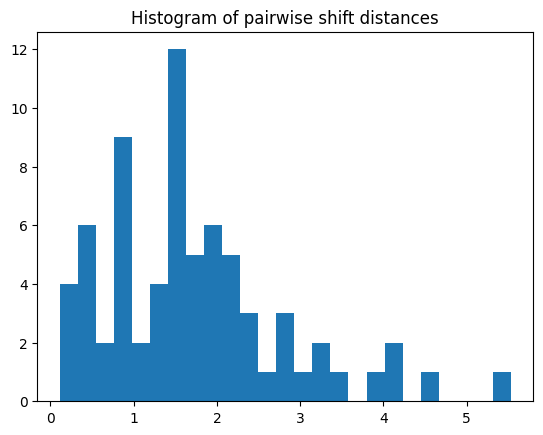

<Figure size 640x480 with 0 Axes>

In [53]:
pairwise_shifts = np.array(list(shifts.values()))
pairwise_shift_dists = np.linalg.norm(pairwise_shifts, axis=1)
plt.title("Histogram of pairwise shift distances")
plt.hist(pairwise_shift_dists, bins=25)
plt.show()
plt.clf()

Print the shifts in order of magnitude

In [60]:
# Negate to sort largest to smallest
sorting_shift_inds = np.argsort(-pairwise_shift_dists)
dataset_ids = np.array(list(shifts.keys()))

shifts_per_dataset_sorted = [
    (tuple(k), v)
    for k, v in zip(
        dataset_ids[sorting_shift_inds], pairwise_shift_dists[sorting_shift_inds]
    )
]
pprint.pprint(shifts_per_dataset_sorted)

[(('000570', '000908'), 5.529774582228827),
 (('000573', '000908'), 4.544461329845763),
 (('000630', '000931'), 4.072871687761974),
 (('000621', '000926'), 4.041261537083093),
 (('000580', '000921'), 3.8650656269735197),
 (('000622', '000925'), 3.5774152705507087),
 (('000580', '000627'), 3.3083548409333465),
 (('000623', '000924'), 3.2416680664064574),
 (('000627', '000921'), 3.0289126067884715),
 (('000620', '000930'), 2.8853715071340105),
 (('000620', '000927'), 2.802833218906405),
 (('000578', '000913'), 2.731837616562953),
 (('000555', '000911'), 2.6811931509248925),
 (('000546', '000613'), 2.380017999112925),
 (('000567', '000912'), 2.3647249844738014),
 (('000559', '000612'), 2.357535977381794),
 (('000576', '000913'), 2.267340191570568),
 (('000574', '000612'), 2.2154850233152668),
 (('000479', '000613'), 2.206237993240381),
 (('000578', '000614'), 2.1856263101875433),
 (('000547', '000911'), 2.1803384675243547),
 (('000479', '000611'), 2.049167392940612),
 (('000570', '000611'

Show the histogram of per-dataset final shifts that were obtained from the least squares solver

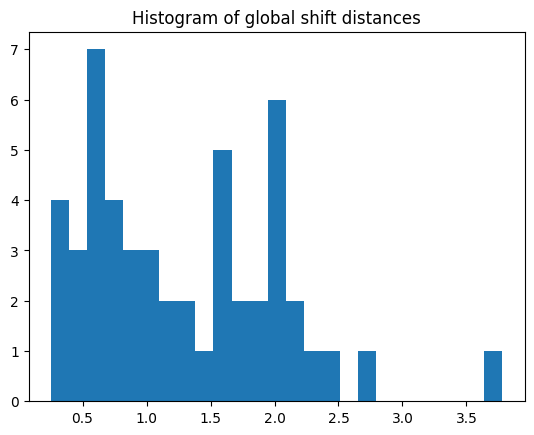

In [55]:
global_shift_values = np.array(list(global_shifts.values()))
global_shift_dists = np.linalg.norm(global_shift_values, axis=1)
plt.title("Histogram of global shift distances")
plt.hist(global_shift_dists, bins=25)
plt.show()